In [1]:
from importlib import reload
import IntersectionDataset
reload(IntersectionDataset)
from IntersectionDataset import IntersectionDataset, IntersectionDataset2

import os
import numpy as np

import matplotlib.pyplot as plt

import random
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F

In [2]:
dataset_dir = "dataset/train"
img_transform = None
path_transform = None
dataset = IntersectionDataset2(root_dir=dataset_dir,
                              transform=img_transform,
                              path_transform=path_transform)

len(dataset) # satellite, path_line, ee_data, cold_map

904

In [3]:
d = [dataset[random.randint(0, 112)] for _ in range(2)]
d0 = dataset[0]
sat_image = d0["satellite"]
path_line = d0["paths"][0]["path_line"]

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(sat_image)
plt.axis('off')
fig.tight_layout()
fig.savefig("img/sat_image.png")
plt.show()

In [ ]:
sat_image = d[0]['satellite']
path_line = d[0]['paths'][0]["path_line"]

fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(sat_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(path_line)
plt.axis('off')
plt.tight_layout()


## Satellite image only
### Saturation

In [45]:
def saturation_aug(image, val = [6, 8, 10]):
    v = random.choice(val)
    img = T.ToTensor()(image)
    img = F.adjust_saturation(img, v)
    
    return T.ToPILImage()(img)

In [ ]:
satured_sat = saturation_aug(sat_image)

rows, cols = 1, 6

fig = plt.figure(figsize=(18, 7))

i = 1
while i <= rows * cols:
    s = random.randint(0, 112)
    fig.add_subplot(rows, cols, i)
    sat = dataset[s]['satellite']
    plt.imshow(sat)
    plt.axis('off')
    i += 1
      
    fig.add_subplot(rows, cols, i)
    plt.imshow(saturation_aug(sat, [6]))
    plt.axis('off')
    i += 1
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(saturation_aug(sat, [10]))
    plt.axis('off')
    i += 1

fig.tight_layout()
#fig.save
plt.show()

### Hue

In [47]:
def skewed_uniform(a, b, alpha=0.5, beta=0.5):
    beta_value = random.betavariate(alpha, beta)

    return a + (b - a) * beta_value

def hue_aug(image, lower = -0.5, upper = 0.5):
    img = T.ToTensor()(image)
    #img = F.adjust_hue(img, random.uniform(lower, upper))
    img = F.adjust_hue(img, skewed_uniform(lower, upper))
    
    return T.ToPILImage()(img)

In [ ]:
rows, cols = 2, 5

fig = plt.figure(figsize=(20, 8))

vals = range(0, 10, 2)
for i, val in enumerate(vals):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(hue_aug(sat_image))
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### Greyscale

In [49]:
def greyscale_aug(image):
    return saturation_aug(image, [0])

In [ ]:
rows, cols = 1, 2

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(rows, cols, 1)
plt.imshow(sat_image)
fig.add_subplot(rows, cols, 2)
plt.imshow(greyscale_aug(sat_image))

In [ ]:
rows, cols = 4, 8
ratio = cols/rows
f_width = 20
f_height = f_width/ratio

fig = plt.figure(figsize=(f_width, f_height))
i = 1
while i <= cols:
    s = random.randint(0, 112)
    fig.add_subplot(rows, cols, i)
    sat = dataset[s]['satellite']
    plt.imshow(sat)
    plt.axis('off')
    
    fig.add_subplot(rows, cols, i+cols)
    plt.imshow(greyscale_aug(sat))
    plt.axis('off')
    
    fig.add_subplot(rows, cols, i+(2*cols))
    plt.imshow(hue_aug(sat))
    plt.axis('off')
    
    fig.add_subplot(rows, cols, i+(3*cols))
    plt.imshow(saturation_aug(sat, [4]))
    plt.axis('off')
        
    i += 1
    
fig.tight_layout()
fig.savefig("augmented.png", transparent=True)
plt.show()

### Noise

In [63]:
def noise_aug(image, mean = 0, std_l = 0.1, std_u = 0.5):
    img = T.ToTensor()(image)
    std = random.uniform(std_l, std_u)
    noise = torch.randn(img.size()) * std + mean
    img = img + noise
    img = torch.clamp(img, 0, 1)
    
    return T.ToPILImage()(img)

In [ ]:
rows, cols = 1, 4
ratio = cols/rows
f_width = 20
f_height = f_width/ratio

fig = plt.figure(figsize=(f_width, f_height))

vals = [i/10 for i in range(0, 2*cols, 2)]
for i, val in enumerate(vals):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(noise_aug(sat_image))
    plt.axis('off')
    
fig.tight_layout()
fig.savefig("img/noise_aug.png", transparent=True)
plt.show()

### Blur

In [73]:
def blur_aug(image, kernel_size = [5, 7, 9], sigma = [1.5, 2, 2.5]):
    kernel_size = random.choice(kernel_size)
    sigma = random.choice(sigma)
    img = T.ToTensor()(image)
    img = F.gaussian_blur(img, kernel_size, sigma)
    
    return T.ToPILImage()(img)

In [ ]:
rows, cols = 1, 4
ratio = cols/rows
f_width = 20
f_height = f_width/ratio

fig = plt.figure(figsize=(f_width, f_height))

vals = [i/10 for i in range(0, 2*cols, 2)]
for i, val in enumerate(vals):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(blur_aug(sat_image))
    plt.axis('off')
    
fig.tight_layout()
fig.savefig("img/blur_aug.png", transparent=True)
plt.show()

## Satellite image + path
### Crop

In [5]:
def crop_aug(sat_image, paths, factor = 0.8):
    h, w = sat_image.size
    new_h, new_w = int(h*factor), int(w*factor)
    top = random.randint(0, h - new_h)
    left = random.randint(0, w - new_w)
    img = F.crop(sat_image, top, left, new_h, new_w)
    scaled_img = F.resize(img, (h, w))
    
    
    path_images = []
    for p in paths:
        path = p["path_line"]
        path_img = F.crop(path, top, left, new_h, new_w)
        scaled_path = F.resize(path_img, (h, w), interpolation=Image.LANCZOS)
        path_images.append(scaled_path)
    
    return scaled_img, path_images

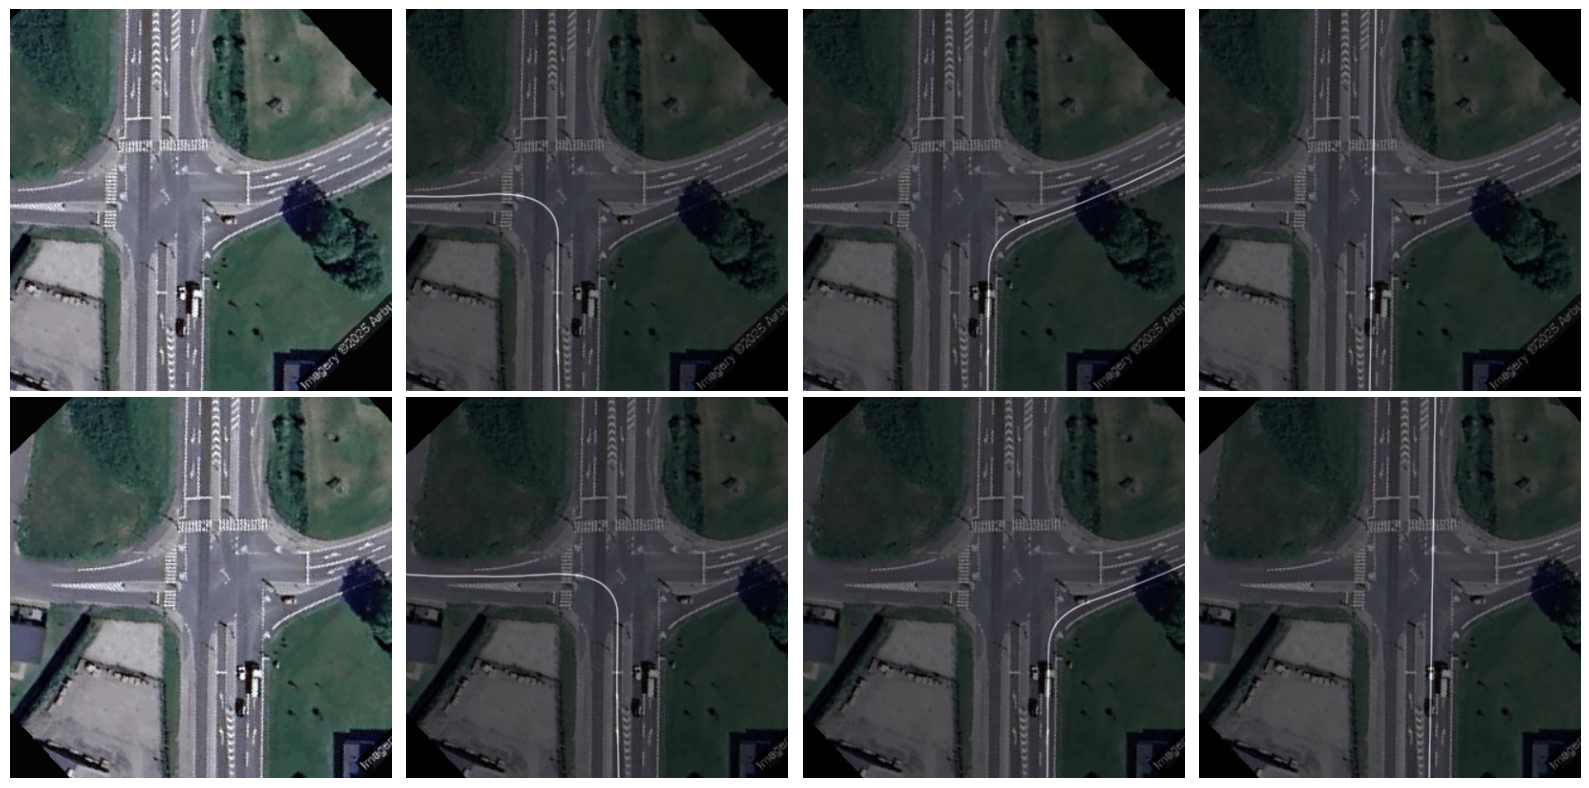

In [ ]:
j = 1
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 8))

i = 1
while i < rows*cols:
    img, paths = crop_aug(sat_image, d['paths'])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    i += 1
    for path in paths:
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.imshow(path, alpha=0.5)
        plt.axis('off')
        i += 1
        
    
        
    
    
plt.tight_layout()
plt.show()

### Zoom

In [4]:
def zoom_aug(image, paths, zoom_range = (1.4, 1.9)):
    zoom_factor = random.uniform(*zoom_range)
    img = F.resize(image, (int(image.size[0]*zoom_factor), int(image.size[1]*zoom_factor)))
    img = F.center_crop(img, image.size)
    
    path_images = []
    for p in paths:
        path = p["path_line"]
        path_img = F.resize(path, (int(path.size[0]*zoom_factor), int(path.size[1]*zoom_factor)))
        path_img = F.center_crop(path_img, image.size)
        path_images.append(path_img)
    
    return img, path_images

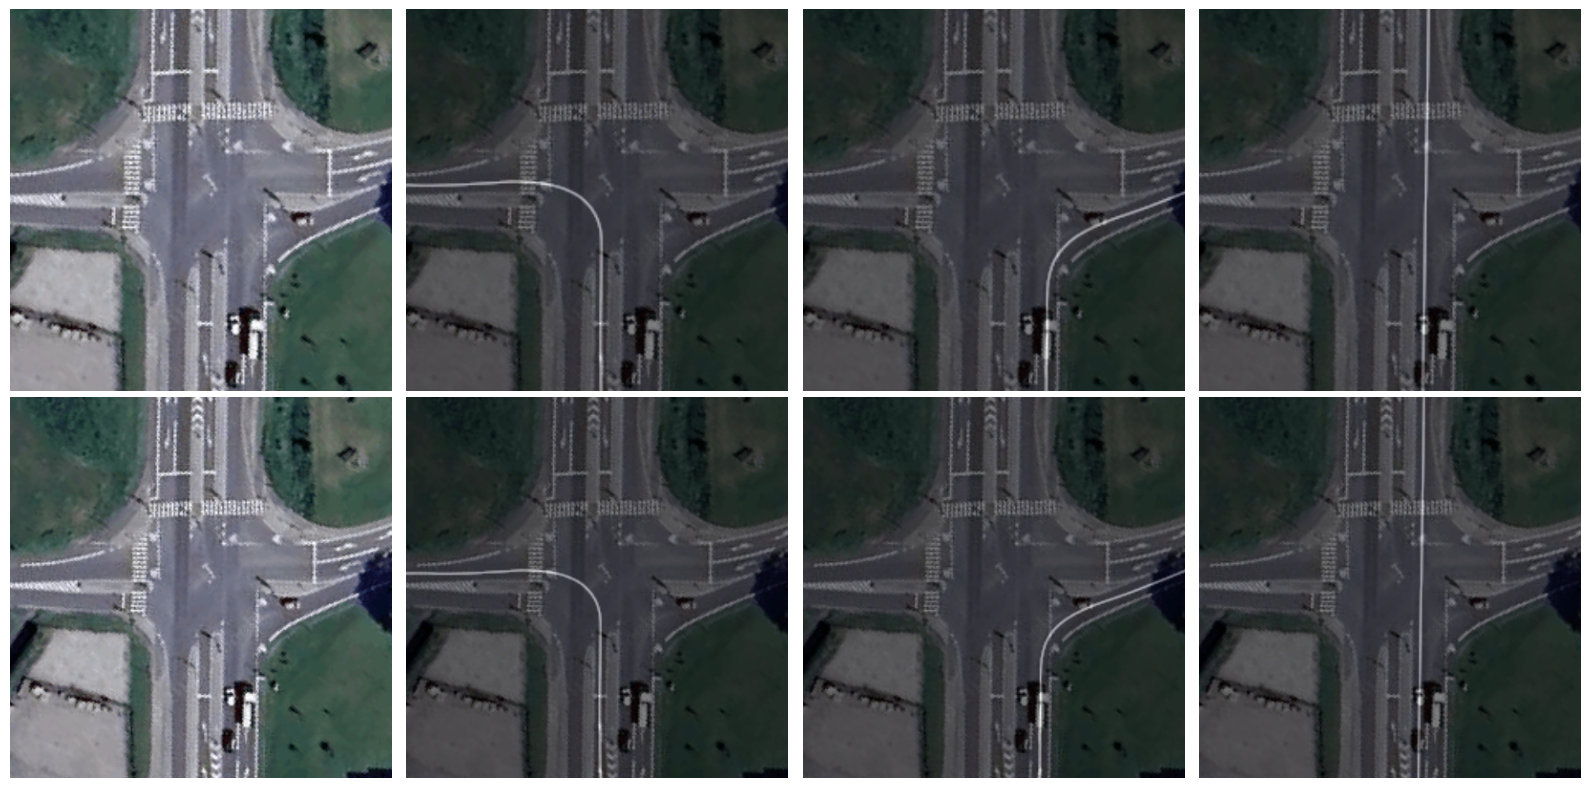

In [232]:
j = 1
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 8))

i = 1
while i < rows*cols:
    img, paths = zoom_aug(sat_image, d['paths'])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    i += 1
    for path in paths:
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.imshow(path, alpha=0.5)
        plt.axis('off')
        i += 1
        
    
    
plt.tight_layout()
plt.show()

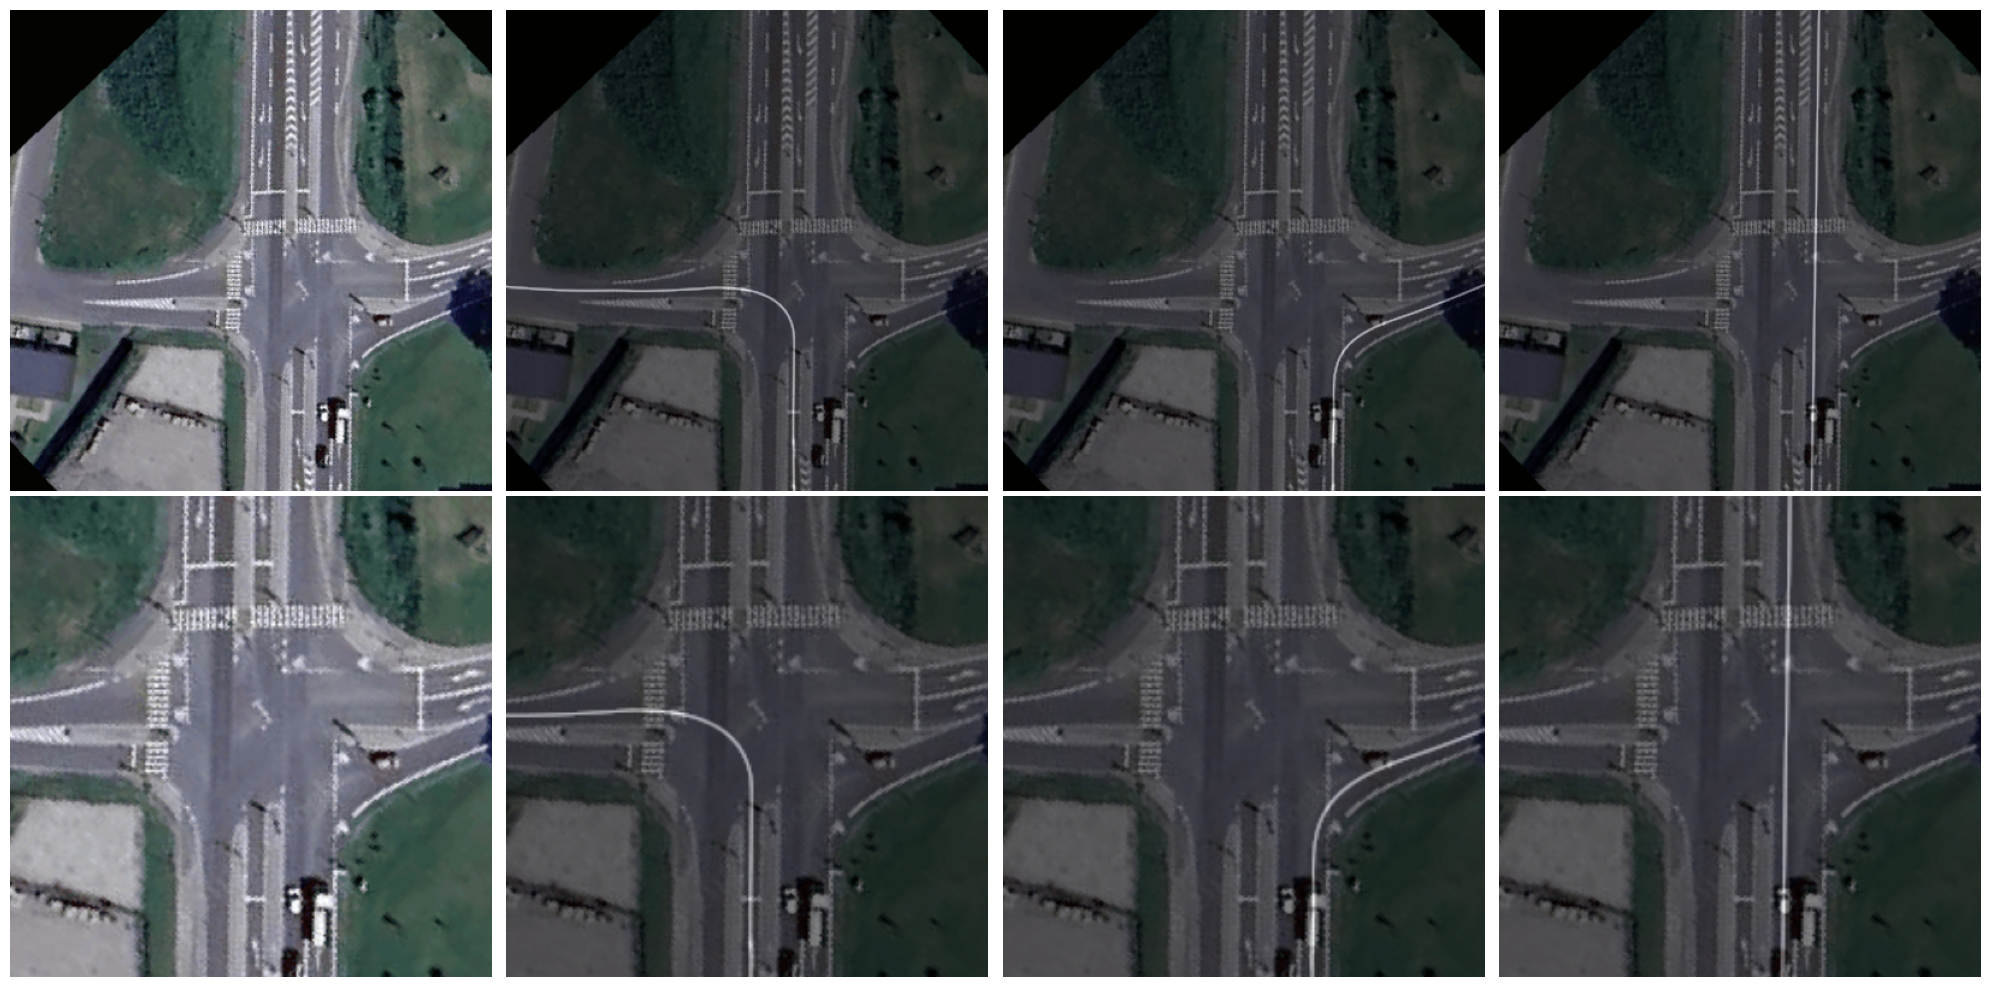

In [14]:
rows, cols = 2, 4
ratio = cols/rows
f_width = 20
f_height = f_width/ratio

fig = plt.figure(figsize=(f_width, f_height))

i = 1
while i < rows*cols:
    img, paths = crop_aug(sat_image, d0['paths'])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    i += 1
    for path in paths:
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.imshow(path, alpha=0.5)
        plt.axis('off')
        i += 1
        
    img, paths = zoom_aug(sat_image, d0['paths'], (1.89, 1.9))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    i += 1
    for path in paths:
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.imshow(path, alpha=0.5)
        plt.axis('off')
        i += 1
        
fig.tight_layout()
fig.savefig("img/crop_zoom_aug.png", transparent=True)
plt.show()

## Putting together

In [191]:
d = dataset[0]
img = d["satellite"]
paths = d["paths"]

In [247]:
dataset_dir = "dataset/train"
i = 113
limit = 900
while i < limit:
    entry = random.choice(dataset)
    ## satellite only augs
    sat_image = entry["satellite"]
    
    # saturation
    for _ in range(2):
        satured_sat = saturation_aug(sat_image)
        
        intersection_folder = f"intersection_{i:03d}"
        intersection_out = os.path.join(dataset_dir, intersection_folder)
        os.makedirs(intersection_out, exist_ok=False)
        satured_sat.save(os.path.join(intersection_out, "satellite.png"))
        
        paths_folder = os.path.join(intersection_out, "paths")
        os.makedirs(paths_folder, exist_ok=False)
        for j, path in enumerate(entry["paths"], 1):
            path_X_folder = os.path.join(paths_folder, f"path_{j}")
            os.makedirs(path_X_folder, exist_ok=False)
            path["path_line"].save(os.path.join(path_X_folder, f"path_line.png"))
        
        i += 1
    
    # hue
    for _ in range(2):
        hue_sat = hue_aug(sat_image)
        
        intersection_folder = f"intersection_{i:03d}"
        intersection_out = os.path.join(dataset_dir, intersection_folder)
        os.makedirs(intersection_out, exist_ok=False)
        hue_sat.save(os.path.join(intersection_out, "satellite.png"))
        
        paths_folder = os.path.join(intersection_out, "paths")
        os.makedirs(paths_folder, exist_ok=False)
        for j, path in enumerate(entry["paths"], 1):
            path_X_folder = os.path.join(paths_folder, f"path_{j}")
            os.makedirs(path_X_folder, exist_ok=False)
            path["path_line"].save(os.path.join(path_X_folder, f"path_line.png"))
        
        i += 1
    
    # greyscale
    grey_sat = greyscale_aug(sat_image)
    
    intersection_folder = f"intersection_{i:03d}"
    intersection_out = os.path.join(dataset_dir, intersection_folder)
    os.makedirs(intersection_out, exist_ok=False)
    grey_sat.save(os.path.join(intersection_out, "satellite.png"))
    
    paths_folder = os.path.join(intersection_out, "paths")
    os.makedirs(paths_folder, exist_ok=False)
    for j, path in enumerate(entry["paths"], 1):
        path_X_folder = os.path.join(paths_folder, f"path_{j}")
        os.makedirs(path_X_folder, exist_ok=False)
        path["path_line"].save(os.path.join(path_X_folder, f"path_line.png"))
    
    i += 1
    
    # noise
    for _ in range(2):
        noise_sat = noise_aug(sat_image)
        
        intersection_folder = f"intersection_{i:03d}"
        intersection_out = os.path.join(dataset_dir, intersection_folder)
        os.makedirs(intersection_out, exist_ok=False)
        noise_sat.save(os.path.join(intersection_out, "satellite.png"))
        
        paths_folder = os.path.join(intersection_out, "paths")
        os.makedirs(paths_folder, exist_ok=False)
        for j, path in enumerate(entry["paths"], 1):
            path_X_folder = os.path.join(paths_folder, f"path_{j}")
            os.makedirs(path_X_folder, exist_ok=False)
            path["path_line"].save(os.path.join(path_X_folder, f"path_line.png"))
        
        i += 1
    
    # blur
    for _ in range(2):
        blur_sat = blur_aug(sat_image)
        
        intersection_folder = f"intersection_{i:03d}"
        intersection_out = os.path.join(dataset_dir, intersection_folder)
        os.makedirs(intersection_out, exist_ok=False)
        blur_sat.save(os.path.join(intersection_out, "satellite.png"))
        
        paths_folder = os.path.join(intersection_out, "paths")
        os.makedirs(paths_folder, exist_ok=False)
        for j, path in enumerate(entry["paths"], 1):
            path_X_folder = os.path.join(paths_folder, f"path_{j}")
            os.makedirs(path_X_folder, exist_ok=False)
            path["path_line"].save(os.path.join(path_X_folder, f"path_line.png"))
        
        i += 1
    
    
    ## satellite and path augs
    paths = entry["paths"]
    
    # crop
    for _ in range(2):
        crop_sat, crop_paths = crop_aug(sat_image, paths)
        
        intersection_folder = f"intersection_{i:03d}"
        intersection_out = os.path.join(dataset_dir, intersection_folder)
        os.makedirs(intersection_out, exist_ok=False)
        crop_sat.save(os.path.join(intersection_out, "satellite.png"))
        
        paths_folder = os.path.join(intersection_out, "paths")
        os.makedirs(paths_folder, exist_ok=False)
        for j, path in enumerate(crop_paths, 1):
            path_X_folder = os.path.join(paths_folder, f"path_{j}")
            os.makedirs(path_X_folder, exist_ok=False)
            path.save(os.path.join(path_X_folder, f"path_line.png"))
            
        i += 1
    
    # zoom
    zoom_sat, zoom_paths = zoom_aug(sat_image, paths)
    
    intersection_folder = f"intersection_{i:03d}"
    intersection_out = os.path.join(dataset_dir, intersection_folder)
    os.makedirs(intersection_out, exist_ok=False)
    zoom_sat.save(os.path.join(intersection_out, "satellite.png"))
    
    paths_folder = os.path.join(intersection_out, "paths")
    os.makedirs(paths_folder, exist_ok=False)
    for j, path in enumerate(zoom_paths, 1):
        path_X_folder = os.path.join(paths_folder, f"path_{j}")
        os.makedirs(path_X_folder, exist_ok=False)
        path.save(os.path.join(path_X_folder, f"path_line.png"))
        
    i += 1
    
    #break

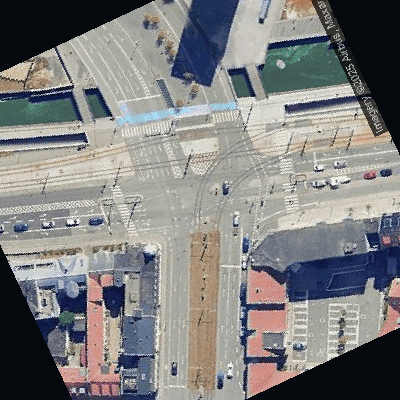

In [241]:
d = random.choice(dataset)
sat_image = d["satellite"]
sat_image